In [1]:
import xarray as xr
import cartopy
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.collections import PatchCollection
from dask.distributed import Client, wait
from matplotlib.patches import Polygon
from pathlib import Path
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import hex2color

In [ ]:
# parameters
connectivity_file_path = "../../output_data/"
connectivity_file_pattern = "035_connection_count_days-travelled-??_bio_phys_agg.nc"


In [3]:
####DASK
client = Client(n_workers=2, threads_per_worker=8, memory_limit=64e9, ip="0.0.0.0")
# client = Client(scheduler_file="../../scheduler.json")
# client.re.start()
client

/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/utils.py:190: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to hostname: [Errno 101] Network is unreachable
  warnings.warn(
/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/utils.py:190: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to hostname: [Errno 101] Network is unreachable
  warnings.warn(
/opt/conda/envs/parcels/lib/python3.12/site-packages/distributed/utils.py:190: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to hostname: [Errno 101] Network is unreachable
  warnings.warn(


<Client: 'tcp://10.0.6.113:44415' processes=2 threads=16, memory=119.21 GiB>

In [4]:
connectivity_file_list = sorted(Path(connectivity_file_path).glob(connectivity_file_pattern))
connectivity_file_list

[PosixPath('../../output_data/035_connection_count_days-travelled-00_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-01_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-02_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-03_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-04_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-05_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-06_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-07_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-08_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-09_bio_phys_agg.nc'),
 PosixPath('../../output_data/035_connection_count_days-travelled-10_bio_phys_agg.nc'),
 PosixPath('../../output_data/03

In [5]:
def load_and_clean_connectivity_files(connectivity_file_list, chunks=None):
    # Set default chunks. Note that we don't chunk in the hex1 direction, 
    # because the alignment would have to do a lot of mixing of the original chunks.
    if chunks is None:
        chunks={"hex0": 1000, "month": 1, "year": 1}

    # concatenate after adding days_travelled to each file
    ds = xr.concat(
        [
            xr.open_dataset(_df, chunks=chunks).assign_coords(days_travelled=_dt)
            for _dt, _df in enumerate(connectivity_file_list)
        ],
        dim="days_travelled",
    )

    # Fix aligned coords and aux data vars.
    # Note that we average in the days_travelled direction to erase undefined
    # values in some days_travelled steps.
    
    for coord in ds.coords:
        if "days_travelled" in ds[coord].dims and len(ds[coord].dims) > 1:
            ds[coord] = ds[coord].mean("days_travelled").compute()

    for var in ds.data_vars:
        if (var.endswith("_hex0") or var.endswith("_hex1")) and ("days_travelled" in ds[var].dims):
            ds[var] = ds[var].mean("days_travelled").compute()

    return ds

In [6]:
ds = load_and_clean_connectivity_files(connectivity_file_list)
ds

<xarray.Dataset> Size: 327GB
Dimensions:              (hex0: 8383, hex1: 8402, days_travelled: 29, month: 5,
                          year: 4, corner: 7)
Coordinates: (12/14)
  * hex0                 (hex0) <U47 2MB '(-1, -19, 20)' ... '(9, 9, -18)'
  * hex1                 (hex1) <U47 2MB '(-1, -19, 20)' ... '(9, 9, -18)'
  * month                (month) float64 40B 0.0 1.0 2.0 3.0 4.0
  * year                 (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0_corners     (corner, hex0) float64 469kB nan -3.076 ... -0.6406
    lat_hex0_corners     (corner, hex0) float64 469kB nan 54.11 ... 56.42 56.58
    ...                   ...
    lon_hex0             (hex0) float64 67kB nan -3.229 ... -0.8121 -0.8032
    lon_hex1             (hex1) float64 67kB -3.216 -3.229 ... -0.8121 -0.8032
    lat_hex0             (hex0) float64 67kB nan 54.11 51.31 ... 56.43 56.58
    lat_hex1             (hex1) float64 67kB 51.46 54.11 51.31 ... 56.43 56.58
    hex_label            (hex0) <U14 469kB '' '(-1, -2, 3)' ... '(9, 9, -18)'
  * days_travelled       (days_travelled) int64 232B 0 1 2 3 4 ... 25 26 27 28
Dimensions without coordinates: corner
Data variables: (12/25)
    aqc_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rst_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pop_count_hex0       (hex0) float64 67kB 1.0 1.0 6.0 0.0 ... 0.0 0.0 0.0 0.0
    dss_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hly_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    his_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                   ...
    depth_mean_hex0      (hex0) float32 34kB nan 7.289 16.08 ... 60.49 60.0 60.0
    depth_mean_hex1      (hex1) float32 34kB 6.895 7.289 16.08 ... 60.0 60.0
    depth_median_hex0    (hex0) float64 67kB nan 5.0 15.0 ... 60.0 60.0 60.0
    depth_median_hex1    (hex1) float64 67kB 5.0 5.0 15.0 ... 60.0 60.0 60.0
    depth_std_hex0       (hex0) float32 34kB nan 3.981 4.406 ... 2.678 0.0 0.0
    depth_std_hex1       (hex1) float32 34kB 3.161 3.981 4.406 ... 2.678 0.0 0.0
Attributes:
    hex_proj__lon_origin:       -3.0
    hex_proj__lat_origin:       54.5
    hex_proj__hex_size_meters:  10000

In [7]:
ds = ds.set_coords([v for v in ds.data_vars if v != "obs"])
ds 

<xarray.Dataset> Size: 327GB
Dimensions:              (hex0: 8383, hex1: 8402, days_travelled: 29, month: 5,
                          year: 4, corner: 7)
Coordinates: (12/38)
    aqc_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rst_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pop_count_hex0       (hex0) float64 67kB 1.0 1.0 6.0 0.0 ... 0.0 0.0 0.0 0.0
    dss_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hly_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    his_count_hex0       (hex0) float64 67kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                   ...
    lon_hex0             (hex0) float64 67kB nan -3.229 ... -0.8121 -0.8032
    lon_hex1             (hex1) float64 67kB -3.216 -3.229 ... -0.8121 -0.8032
    lat_hex0             (hex0) float64 67kB nan 54.11 51.31 ... 56.43 56.58
    lat_hex1             (hex1) float64 67kB 51.46 54.11 51.31 ... 56.43 56.58
    hex_label            (hex0) <U14 469kB '' '(-1, -2, 3)' ... '(9, 9, -18)'
  * days_travelled       (days_travelled) int64 232B 0 1 2 3 4 ... 25 26 27 28
Dimensions without coordinates: corner
Data variables:
    obs                  (days_travelled, month, year, hex0, hex1) float64 327GB dask.array<chunksize=(1, 1, 1, 1000, 8355), meta=np.ndarray>
Attributes:
    hex_proj__lon_origin:       -3.0
    hex_proj__lat_origin:       54.5
    hex_proj__hex_size_meters:  10000

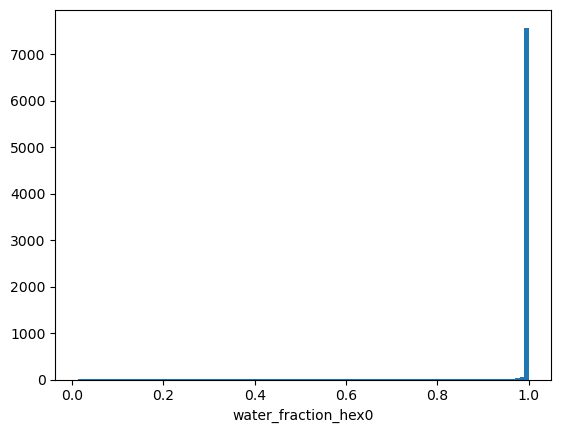

In [8]:
ds.water_fraction_hex0.plot.hist(bins=101);

In [9]:
obs_coastal = (
    ds
    .obs
    .where(ds.water_fraction_hex0 < 1, drop=True)
    #.sum(["month", "year"])
    .isel(year=0, month=0)
    .sum("hex1")
).compute()

In [10]:
from itertools import permutations

In [11]:
hex0_coastal = set(obs_coastal.hex0.data)
hex0_qrs_coastal = set(map(eval, hex0_coastal))
hex0_qrs_coastal_nn_candidates = []
for q, r, s in hex0_qrs_coastal:
    for qo, ro, so in list(permutations([-1, 0, 1])):
        _q, _r, _s = q + qo, r + ro, s + so
        hex0_qrs_coastal_nn_candidates.append((_q, _r, _s))
hex0_qrs_coastal_nn = set(hex0_qrs_coastal_nn_candidates).difference(hex0_qrs_coastal).intersection(set(map(eval, ds.hex0.data)))
len(hex0_qrs_coastal), len(hex0_qrs_coastal_nn)

(798, 676)

In [12]:
hex0_coastal_nn = sorted(map(str, hex0_qrs_coastal_nn))
hex0_coastal = sorted(map(str, hex0_qrs_coastal))

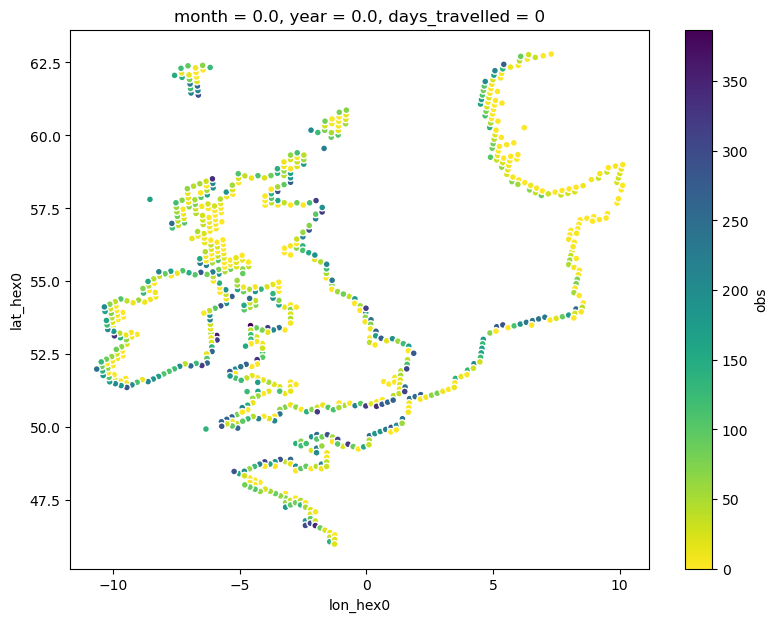

In [13]:
(ds.obs.isel(year=0, month=0, days_travelled=0).sel(hex0=hex0_coastal).sum("hex1") / 24).to_dataset().plot.scatter(x="lon_hex0", y="lat_hex0", s=25, size=7, hue="obs", cmap="viridis_r")

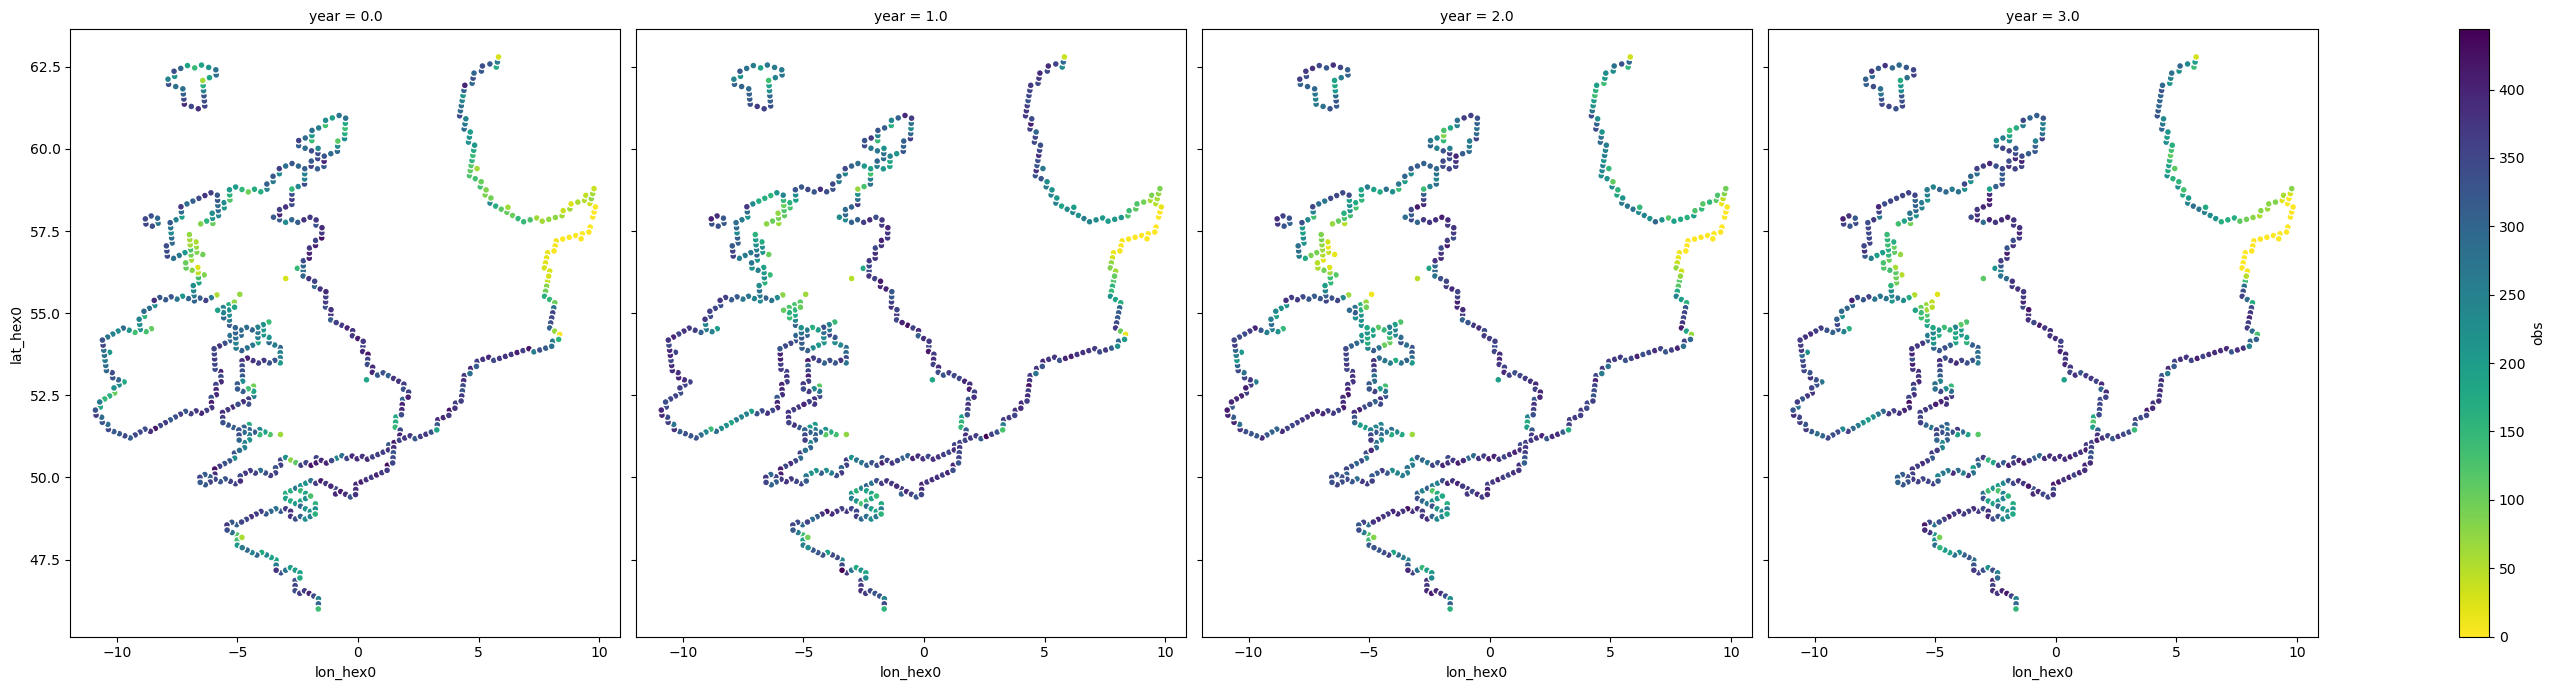

In [14]:
(ds.obs.isel(month=0, days_travelled=0).sel(hex0=hex0_coastal_nn).sum("hex1") / 24).to_dataset().plot.scatter(x="lon_hex0", y="lat_hex0", s=25, size=7, hue="obs", cmap="viridis_r", col="year")

In [15]:
obs_relto_water_fraction = (
    ds.obs.sum(["year", "month", "hex1"]).isel(days_travelled=0)
    / ds.water_fraction_hex0
).to_dataset(name="obs").compute()

In [20]:
obs_valid = (
    (ds.obs.sum(["year", "month", "hex1"]) / 4 / 128 * 4.5 / 24).isel(days_travelled=0)
    # / ds.water_count_hex0
).to_dataset(name="obs").compute()

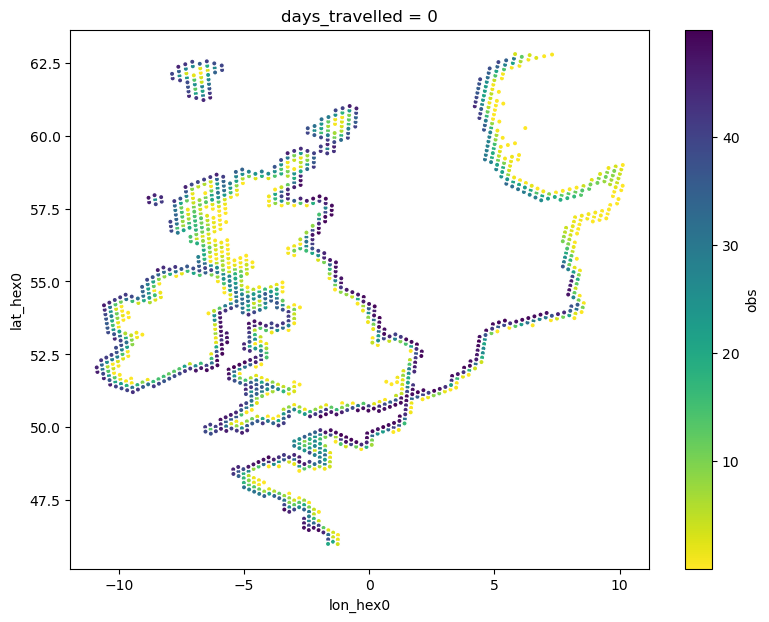

In [21]:
obs_valid.sel(hex0=(hex0_coastal + hex0_coastal_nn)).plot.scatter(x="lon_hex0", y="lat_hex0", s=15, size=7, hue="obs", cmap="viridis_r")

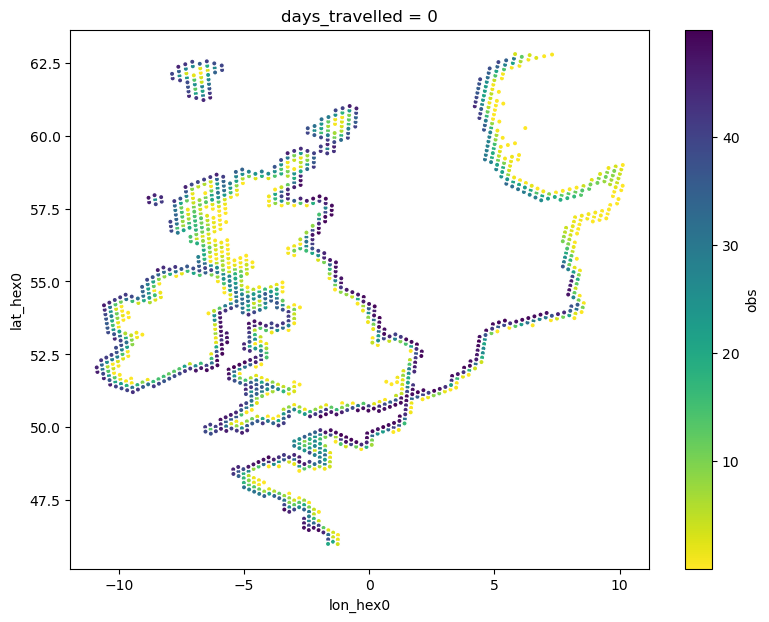

In [22]:
obs_valid.sel(hex0=(hex0_coastal + hex0_coastal_nn)).plot.scatter(x="lon_hex0", y="lat_hex0", s=15, size=7, hue="obs", cmap="viridis_r")

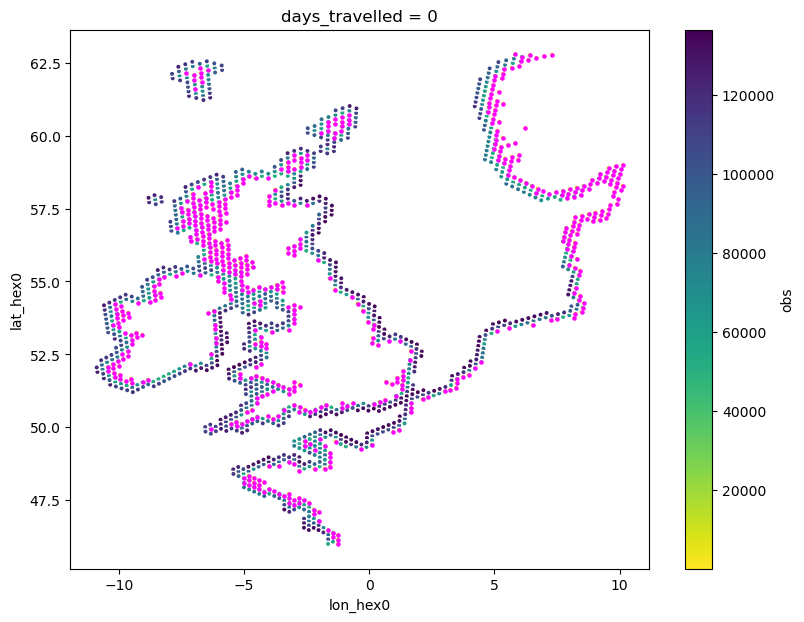

In [23]:
obs_relto_water_fraction.sel(hex0=(hex0_coastal + hex0_coastal_nn)).plot.scatter(x="lon_hex0", y="lat_hex0", s=15, size=7, hue="obs", cmap="viridis_r")
obs_relto_water_fraction.where(obs_relto_water_fraction.compute() < 50_000).sel(hex0=(hex0_coastal + hex0_coastal_nn)).dropna("hex0").plot.scatter(x="lon_hex0", y="lat_hex0", s=5, color="magenta")

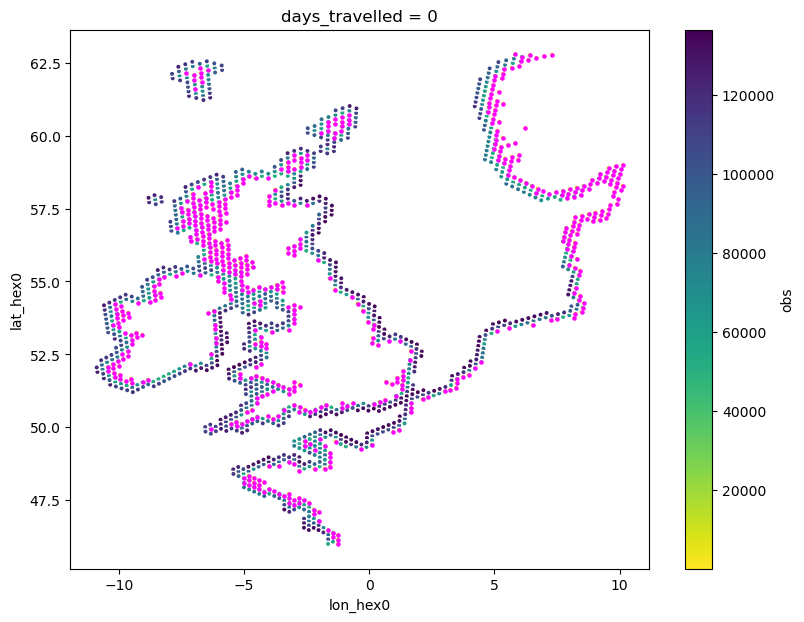

In [24]:
obs_relto_water_fraction.sel(hex0=(hex0_coastal + hex0_coastal_nn)).plot.scatter(x="lon_hex0", y="lat_hex0", s=15, size=7, hue="obs", cmap="viridis_r")
obs_relto_water_fraction.where(obs_relto_water_fraction.compute() < 50_000).sel(hex0=(hex0_coastal + hex0_coastal_nn)).dropna("hex0").plot.scatter(x="lon_hex0", y="lat_hex0", s=5, color="magenta")

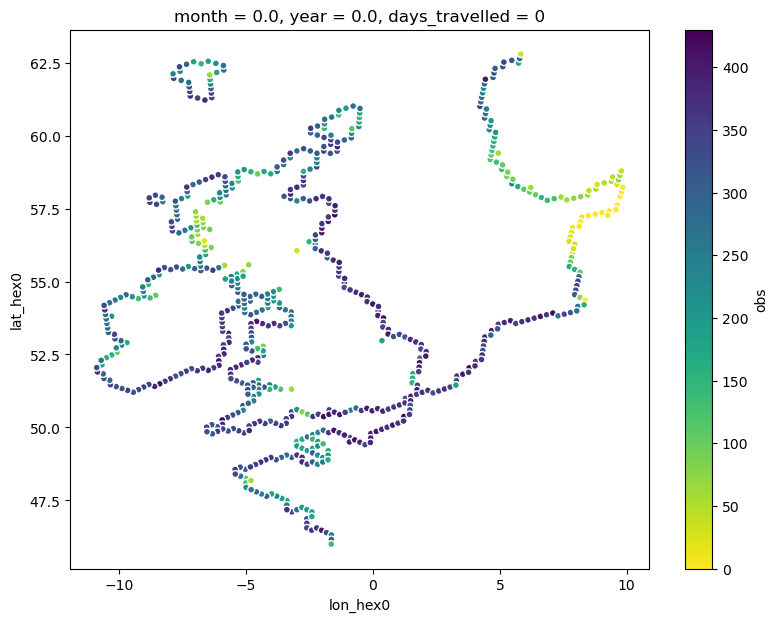

In [27]:
(
    (ds.obs.isel(year=0, month=0, days_travelled=0).sel(hex0=hex0_coastal_nn).sum("hex1") / 24)
    / ds.water_fraction_hex0.sel(hex0=hex0_coastal_nn)
).to_dataset(name="obs").plot.scatter(x="lon_hex0", y="lat_hex0", s=25, size=7, hue="obs", cmap="viridis_r")

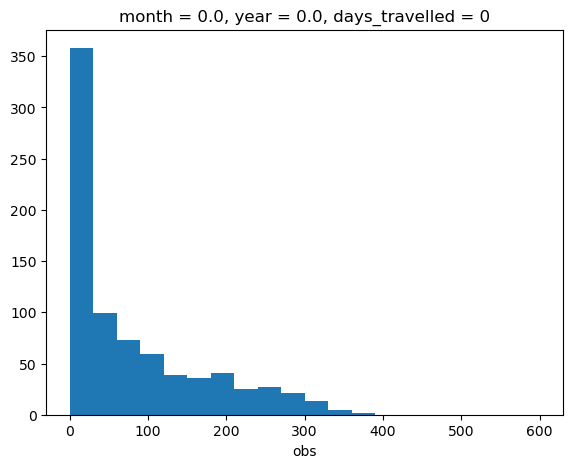

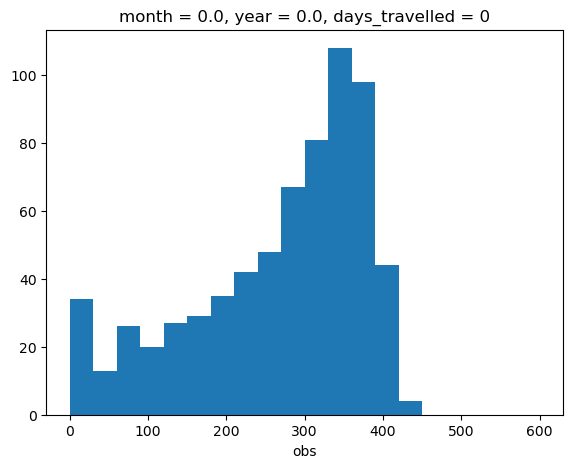

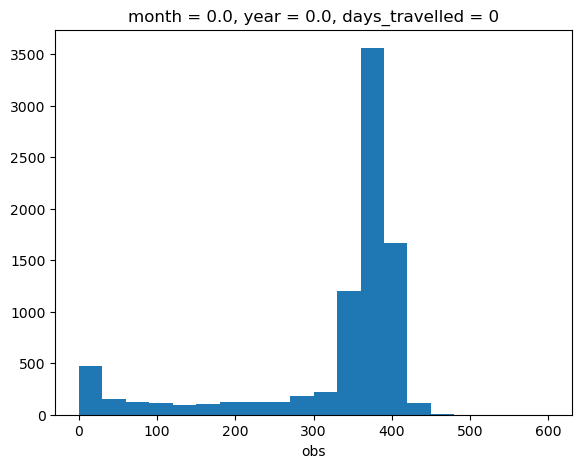

In [28]:
(ds.obs.isel(year=0, month=0, days_travelled=0).sel(hex0=hex0_coastal).sum("hex1") / 24).plot.hist(bins=np.linspace(0, 600, 21), size=5);
(ds.obs.isel(year=0, month=0, days_travelled=0).sel(hex0=hex0_coastal_nn).sum("hex1") / 24).plot.hist(bins=np.linspace(0, 600, 21), size=5);
(ds.obs.isel(year=0, month=0, days_travelled=0).sum("hex1") / 24).plot.hist(bins=np.linspace(0, 600, 21), size=5);

In [37]:
obs_coastal_nn = (
    ds
    .obs
    #.where(ds.water_fraction_hex0 < 1, drop=True)
    .sel(hex0=hex0_coastal_nn)
    #.sum(["month", "year"])
    .isel(year=0, month=0)
    .sum("hex1")
).compute()

In [30]:
obs_all = (
    ds
    .obs
    # .where(ds.water_fraction_hex0 == 1, drop=True)
    .isel(year=0, month=0)
    .sum("hex1")
).compute()

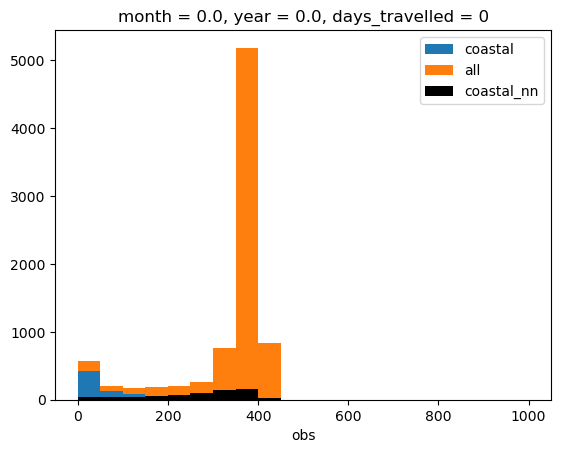

In [54]:
(obs_coastal.isel(days_travelled=0) / 24).plot.hist(bins=np.linspace(0, 1000, 21), label="coastal");
(obs_all.isel(days_travelled=0) / 24).plot.hist(bins=np.linspace(0, 1000, 21), zorder=-2, label="all");
(obs_coastal_nn.isel(days_travelled=0) / 24).plot.hist(bins=np.linspace(0, 1000, 21), zorder=1, color="black", label="coastal_nn");
plt.legend()

In [33]:
from itertools import permutations

In [34]:
list(permutations([-1, 0, 1]))

[(-1, 0, 1), (-1, 1, 0), (0, -1, 1), (0, 1, -1), (1, -1, 0), (1, 0, -1)]

-21 46 -25


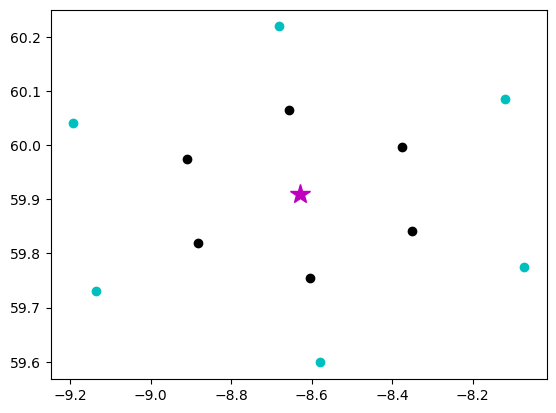

In [35]:
hex0 = '(-21, 46, -25)'
q, r, s = eval(hex0)
print(q, r, s)
plt.plot(obs_all.sel(hex0=str((q, r, s))).lon_hex0, obs_all.sel(hex0=str((q, r, s))).lat_hex0, 'm*', markersize=15)
for qo, ro, so in list(permutations([-2, 0, 2])):
        _q = q + qo
        _r = r + ro
        _s = s + so
        try:
            plt.plot(obs_all.sel(hex0=str((_q, _r, _s))).lon_hex0, obs_all.sel(hex0=str((_q, _r, _s))).lat_hex0, 'co', zorder=-1)
        except:
            print(_q, _r, _s)
for qo, ro, so in list(permutations([-1, 0, 1])):
        _q = q + qo
        _r = r + ro
        _s = s + so
        try:
            plt.plot(obs_all.sel(hex0=str((_q, _r, _s))).lon_hex0, obs_all.sel(hex0=str((_q, _r, _s))).lat_hex0, 'ko', zorder=-1)
        except:
            print(_q, _r, _s)            

In [36]:
obs_coastal.isel(hex0=1234)

IndexError: index 1234 is out of bounds for axis 1 with size 798

In [ ]:
obs_coastal.isel(days_travelled=0, drop=True).plot.hist();

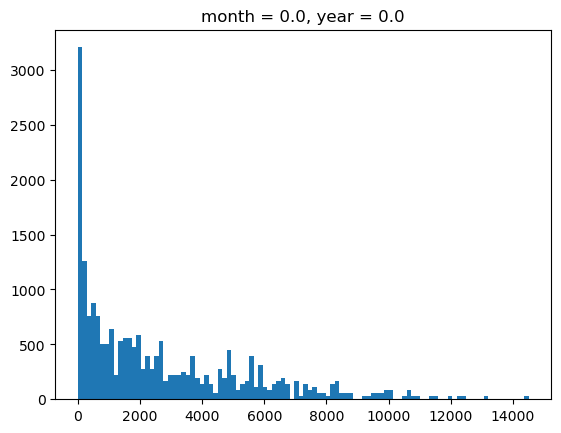

In [13]:
(obs_coastal / obs_coastal.water_fraction_hex0).plot.hist(bins=100);

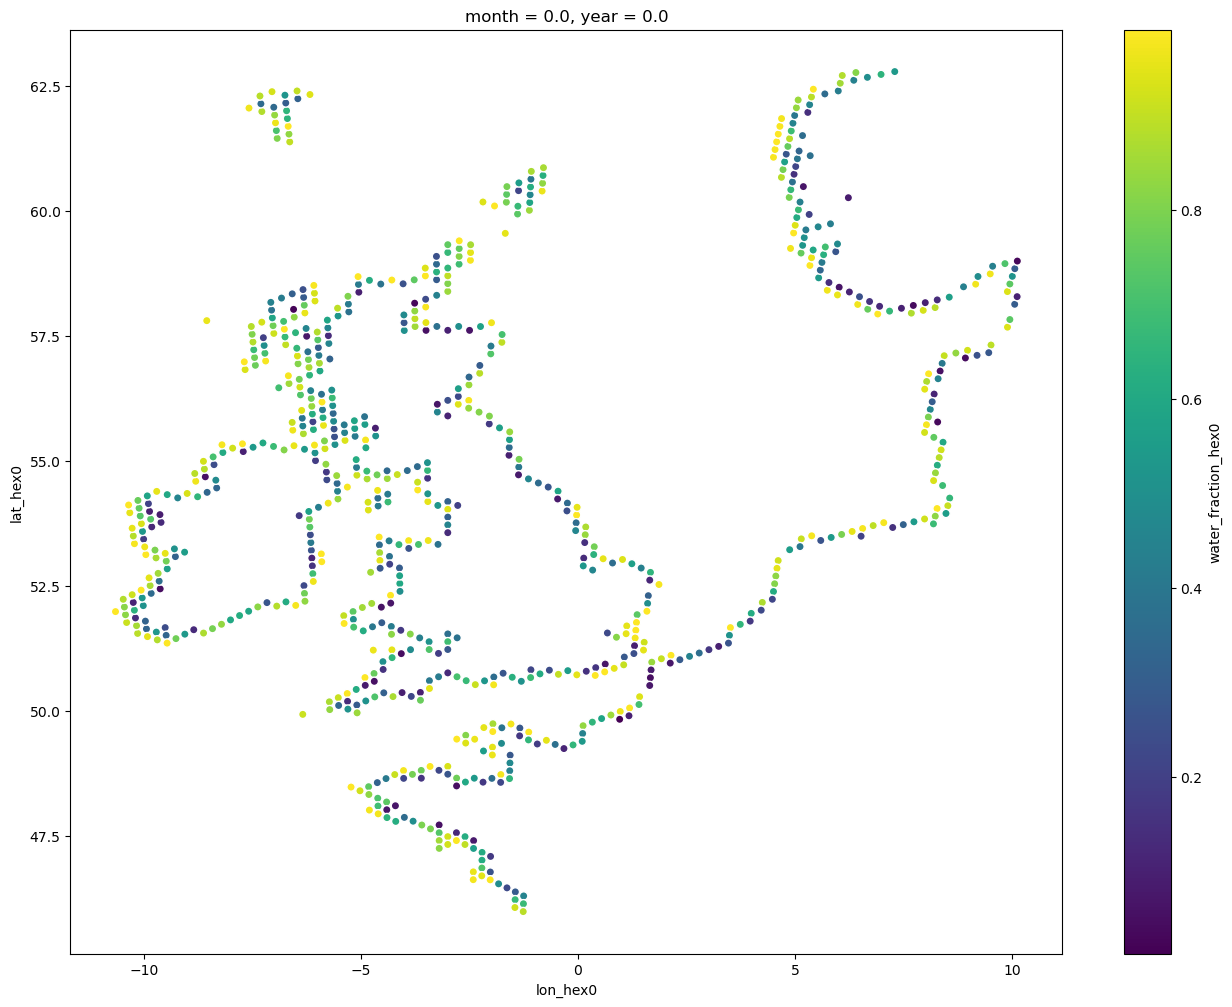

In [35]:
relobs = (1 / (obs_coastal / obs_coastal.water_fraction_hex0)).rename("relobs").sum("days_travelled").to_dataset()
relobs.plot.scatter(x="lon_hex0", y="lat_hex0", hue="water_fraction_hex0", size=12)

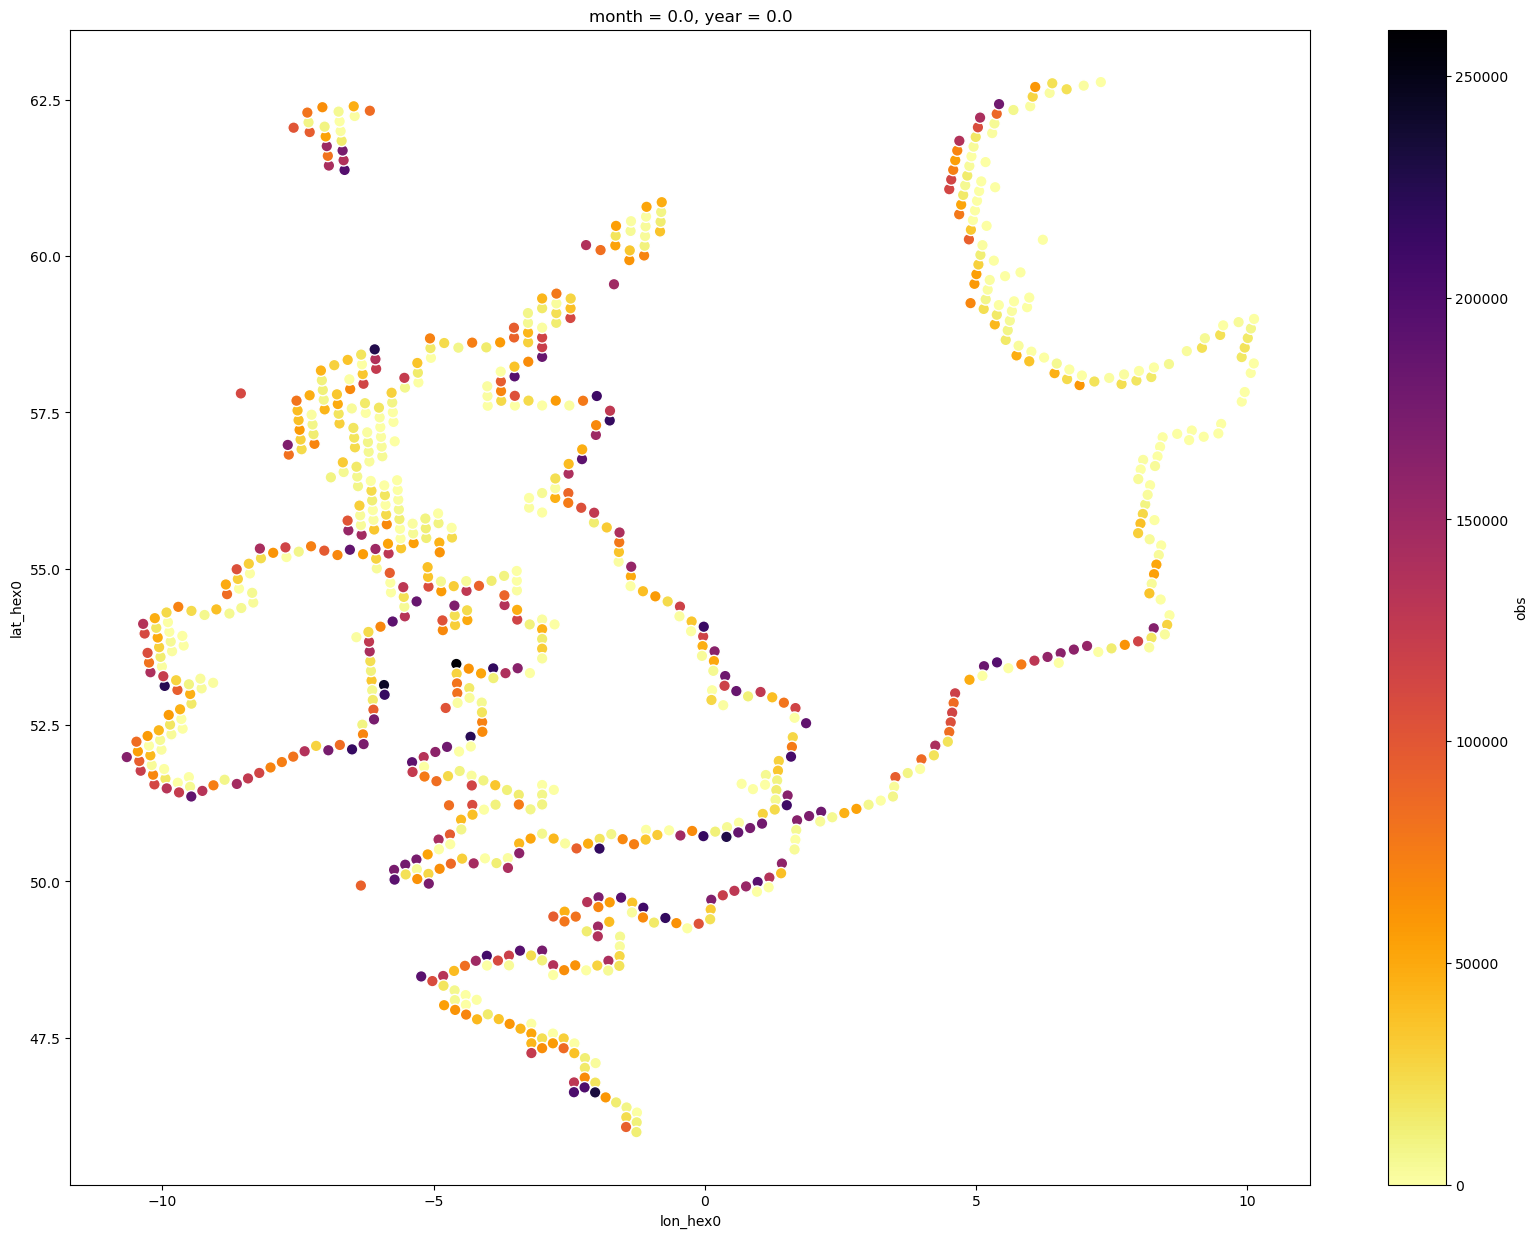

In [36]:
obs_coastal.sum("days_travelled").to_dataset().plot.scatter(
    x="lon_hex0", y="lat_hex0", hue="obs", s=70, size=15, cmap="inferno_r"
)

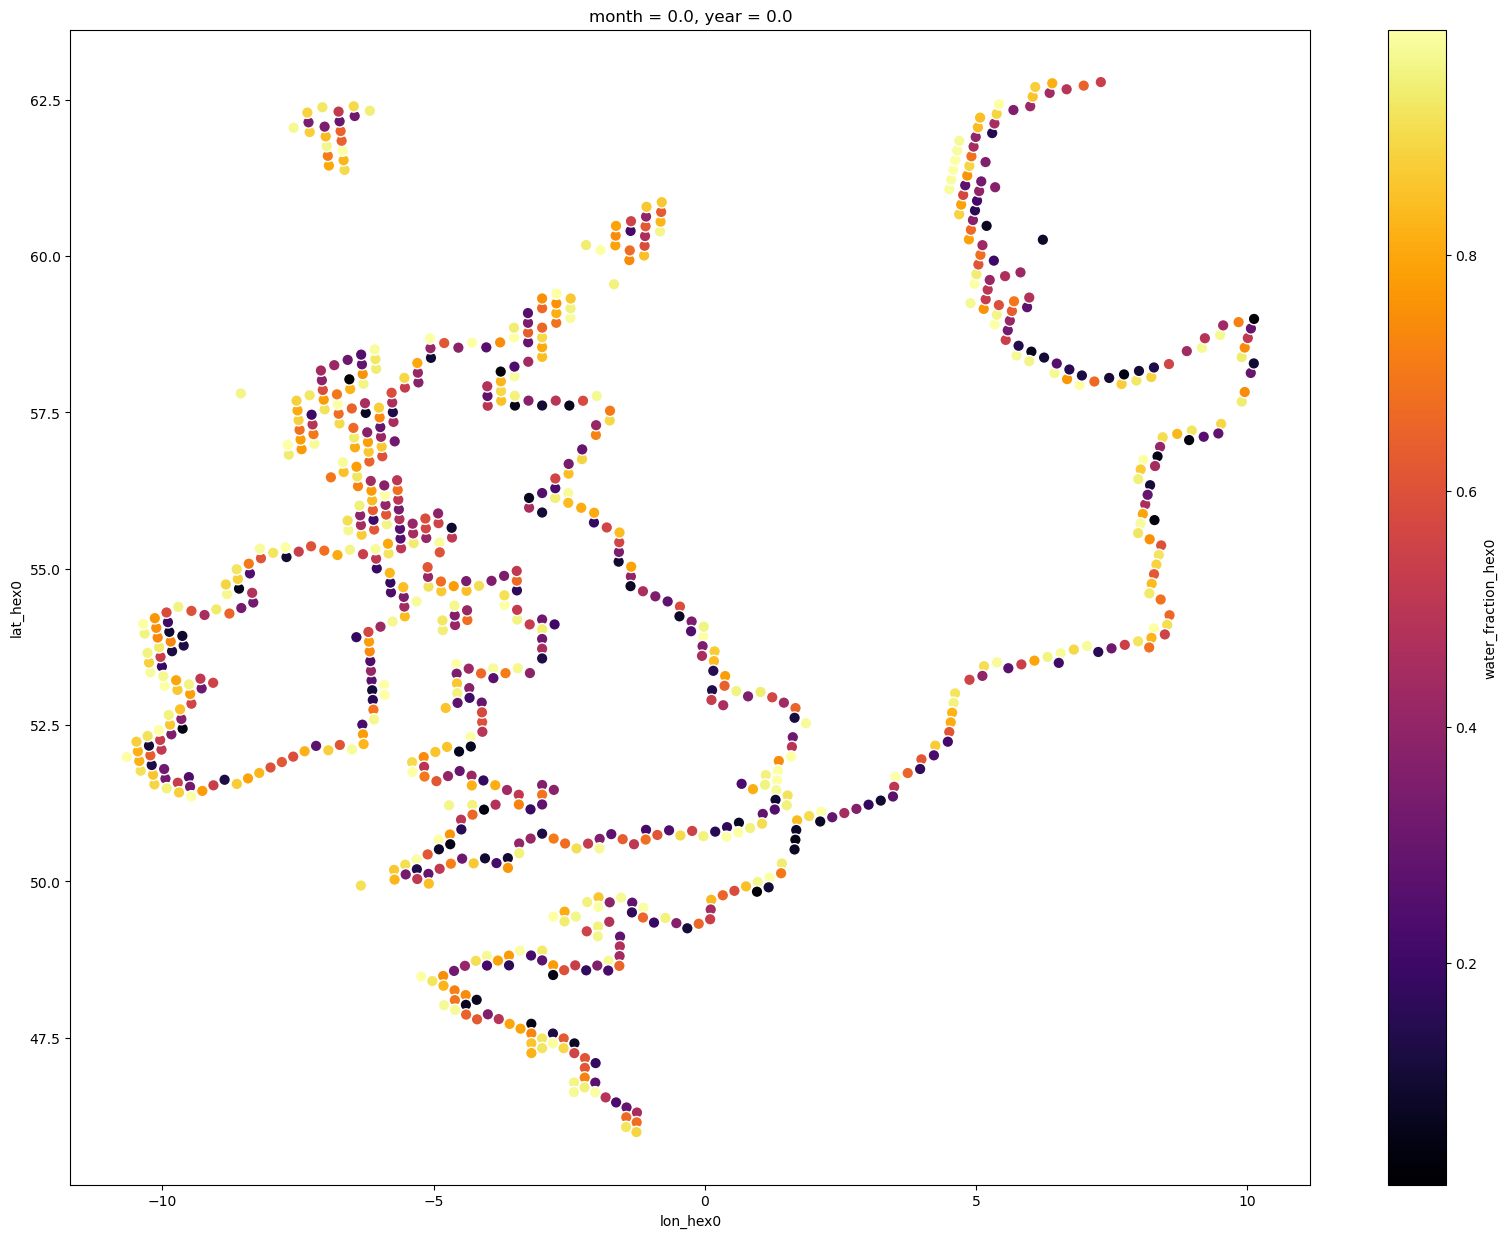

In [31]:
obs_coastal.sum("days_travelled").to_dataset().plot.scatter(
    x="lon_hex0", y="lat_hex0", hue="water_fraction_hex0", s=70, size=15, cmap="inferno"
)

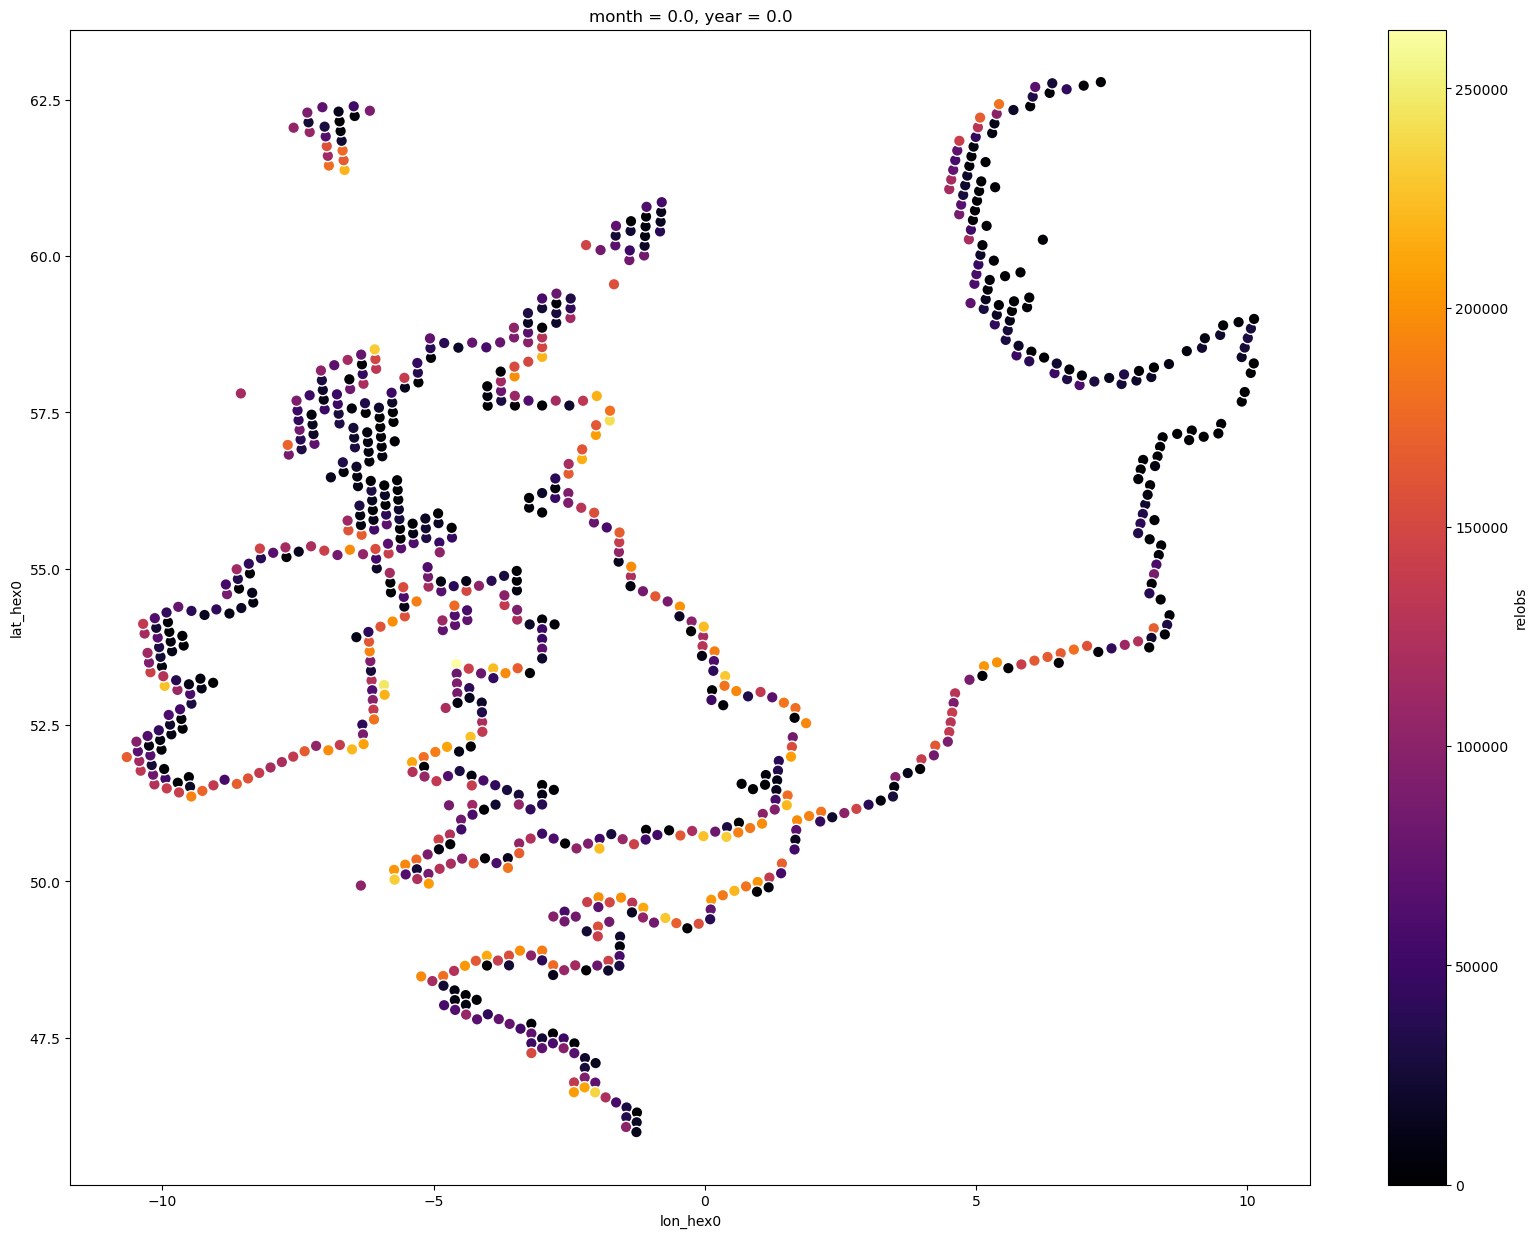

In [32]:
relobs = (obs_coastal / obs_coastal.water_fraction_hex0).rename("relobs")
relobs.sum("days_travelled").to_dataset().plot.scatter(
    x="lon_hex0", y="lat_hex0", hue="relobs", s=70, size=15, cmap="inferno"
)

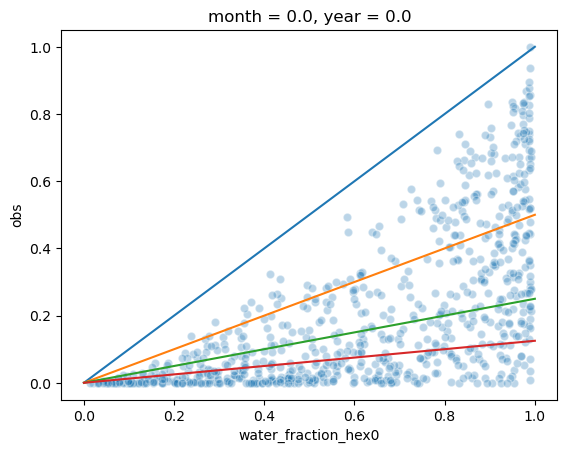

In [38]:
(
    obs_coastal.sum("days_travelled") / obs_coastal.sum("days_travelled").max()
).to_dataset().plot.scatter(
    y="obs", x="water_fraction_hex0", alpha=0.3,
)

plt.plot([0, 1], [0, 1.0])
plt.plot([0, 1], [0, 0.5])
plt.plot([0, 1], [0, 0.25])
plt.plot([0, 1], [0, 0.125])

In [33]:
thresholds = xr.DataArray(np.linspace(0, 1, 9), dims="thres", name="thres")
thresholds

<xarray.DataArray 'thres' (thres: 9)> Size: 72B
array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])
Dimensions without coordinates: thres

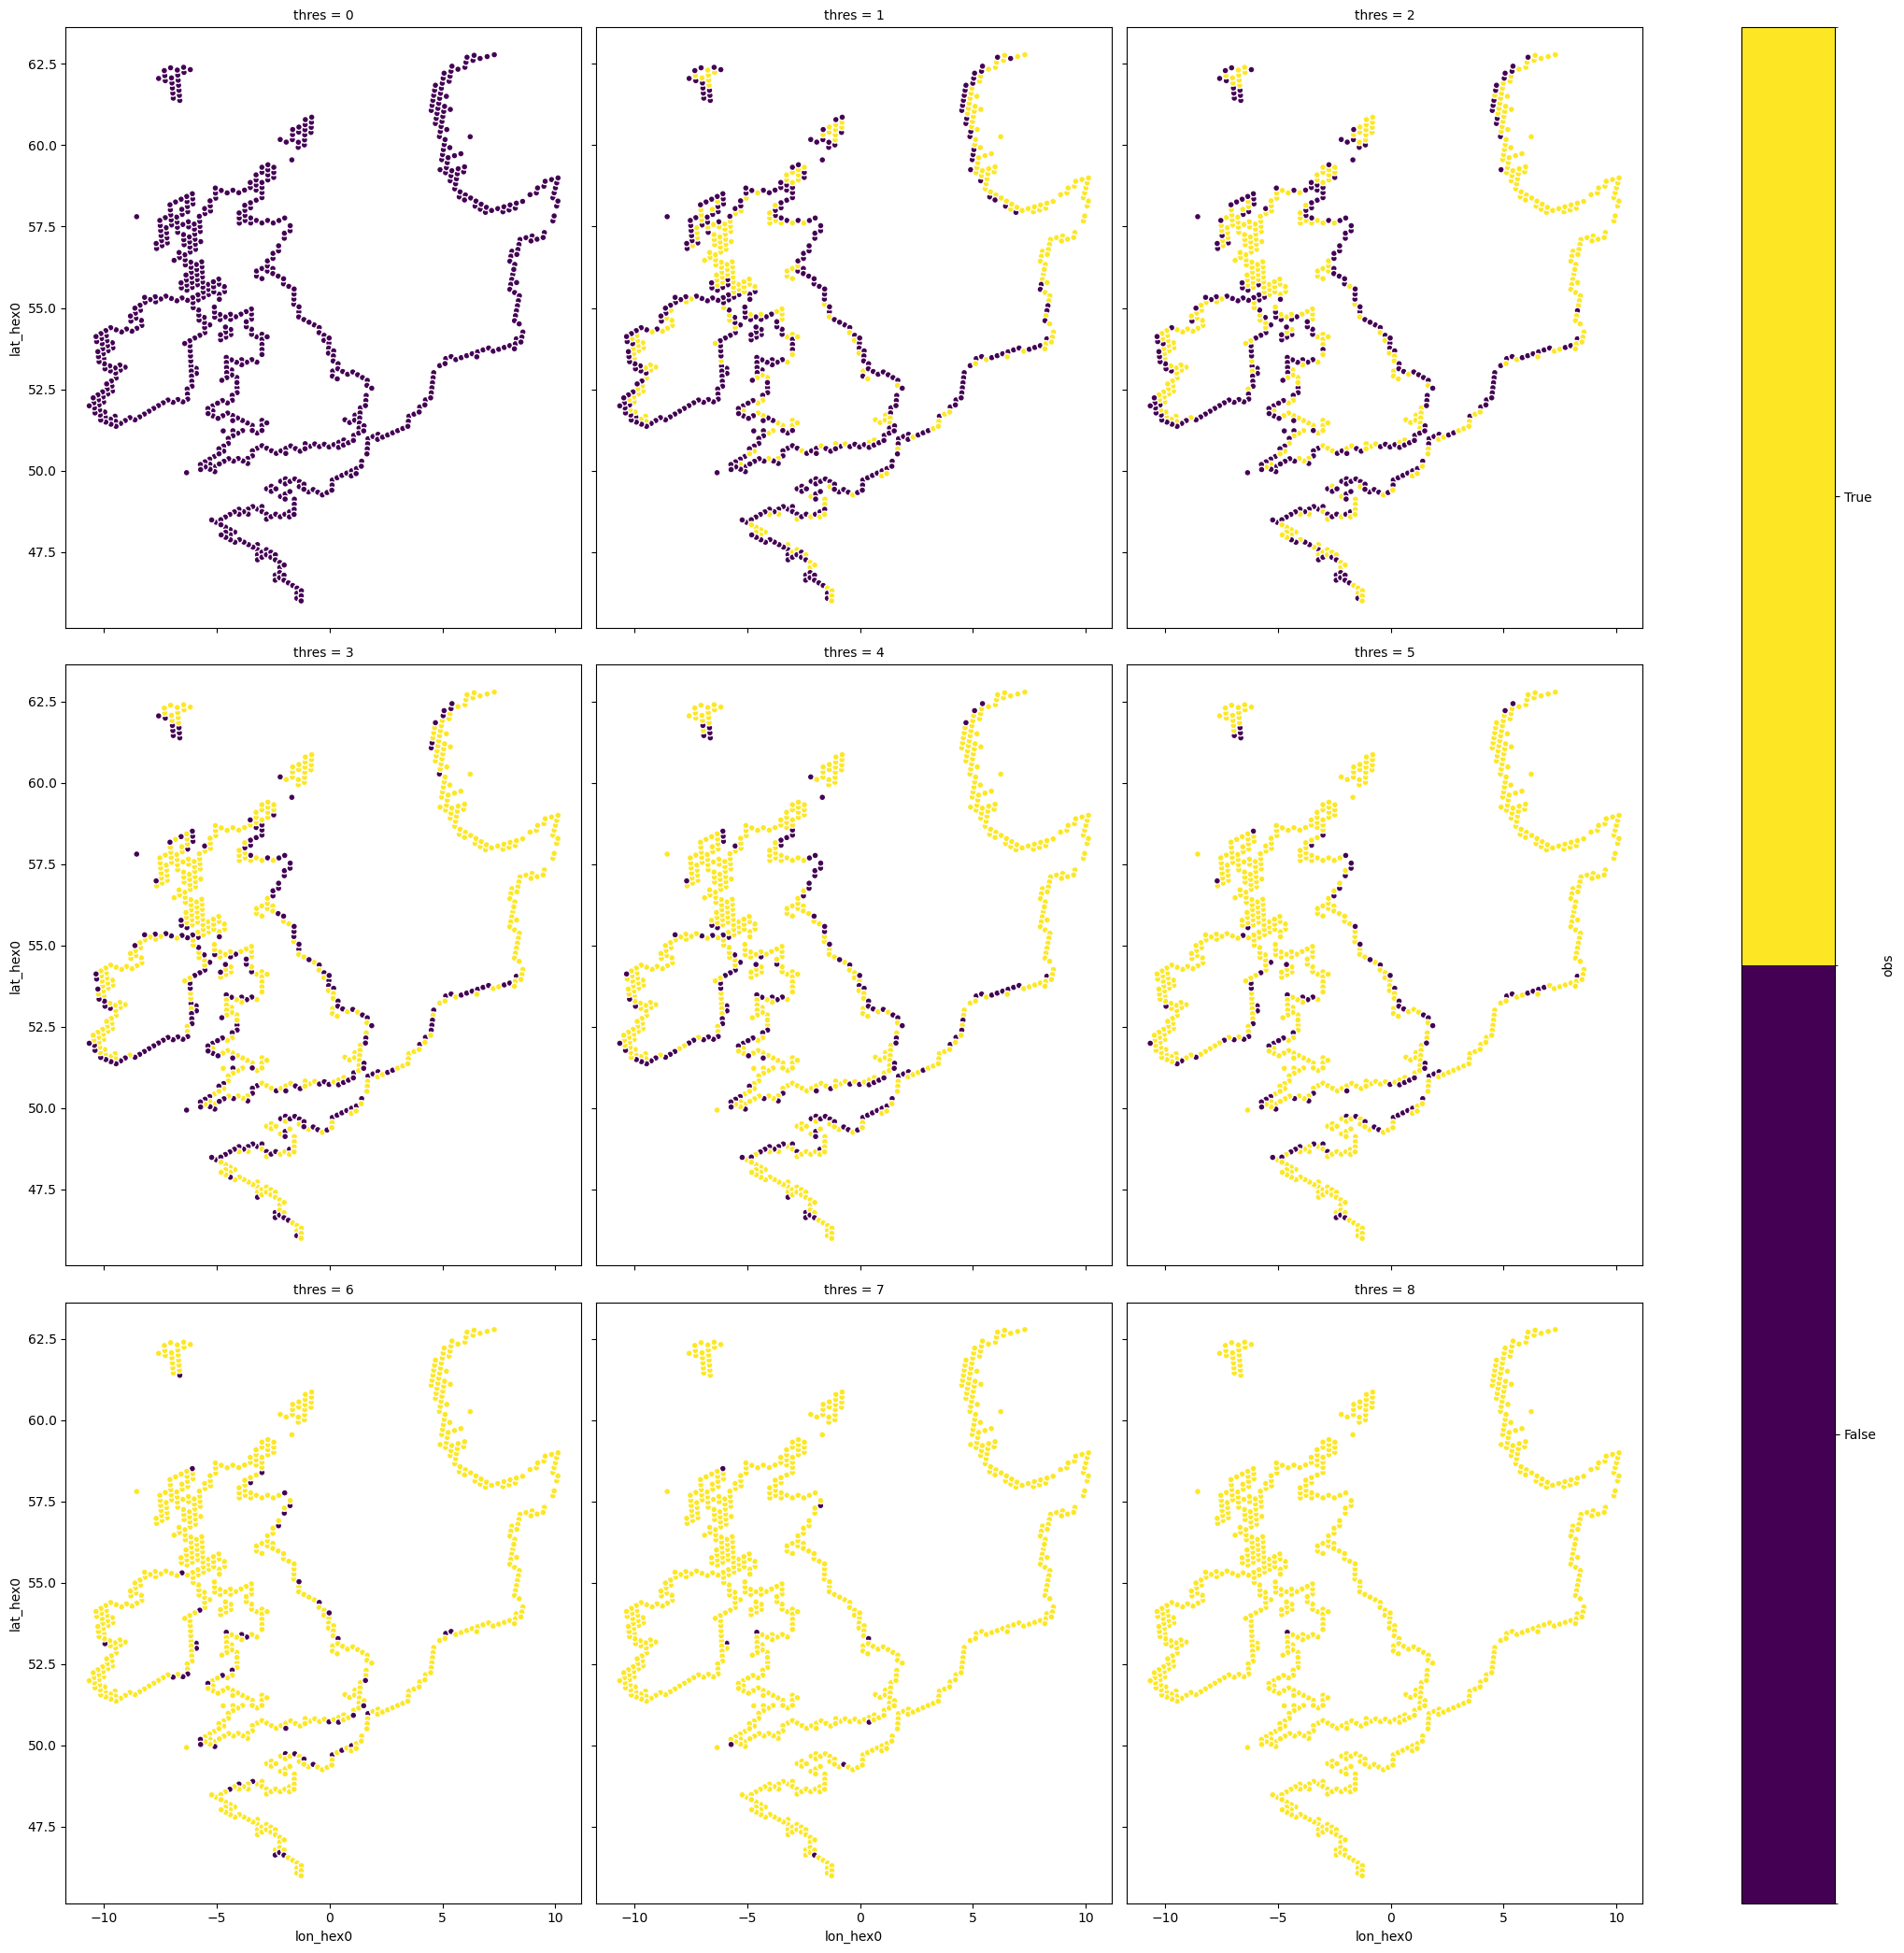

In [34]:
(
    (obs_coastal.sum("days_travelled") / obs_coastal.sum("days_travelled").max()) < thresholds * obs_coastal.water_fraction_hex0
).to_dataset(name="obs").plot.scatter(
    x="lon_hex0", y="lat_hex0", hue="obs",
    s=25, size=7,
    col="thres",
    col_wrap=3,
)